In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("./data_aman/data.csv")

In [4]:
df.head()

,a,d,fl,fw,gh,inl,inw,k,mt,pl,pw,sh,sl,sw,uf,freq,s11,gain,bandwidth
0,50.0,2000.0,75.0,58.0,15.0,80.0,3.625,1.0,15.0,250.0,350.0,90.0,400.0,460.0,0.8,0.38026,-39.578262,9.609153,0.031210
1,50.0,2000.0,75.0,58.0,15.0,80.0,3.625,1.0,15.0,250.0,326.0,90.0,400.0,460.0,0.8,0.38620,-27.972472,9.672313,0.031197
2,50.0,2000.0,75.0,58.0,15.0,80.0,3.625,1.0,15.0,250.0,303.0,90.0,400.0,460.0,0.8,0.39115,-24.776668,9.700339,0.033673
3,50.0,2000.0,75.0,58.0,15.0,80.0,3.625,1.0,15.0,250.0,280.0,90.0,400.0,460.0,0.8,0.39808,-21.830821,9.708912,0.032357
4,50.0,2000.0,75.0,58.0,15.0,58.0,3.625,1.0,15.0,250.0,350.0,90.0,400.0,460.0,0.8,0.38125,-24.694840,9.689270,0.031997


In [5]:
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,a,d,fl,fw,gh,inl,inw,k,mt,pl,pw,sh,sl,sw,uf,freq,s11,gain,bandwidth
0,30.0,2000.0,86.0,58.0,15.0,20.0,3.625,1.0,15.0,228.0,326.0,90.0,400.0,460.0,0.8,0.39709,-29.214939,9.825522,0.035123
1,40.0,2000.0,86.0,58.0,15.0,20.0,3.625,1.0,15.0,228.0,326.0,90.0,400.0,460.0,0.8,0.40204,-35.061318,9.782976,0.036295
2,30.0,2000.0,110.0,58.0,15.0,39.0,3.625,1.0,15.0,180.0,303.0,90.0,400.0,460.0,0.8,0.78418,-38.513951,10.170065,0.111837
3,50.0,2000.0,98.0,58.0,15.0,20.0,3.625,1.0,15.0,204.0,280.0,90.0,400.0,460.0,0.8,0.44362,-22.186413,10.455012,0.040282
4,40.0,2000.0,110.0,58.0,15.0,39.0,3.625,1.0,15.0,180.0,280.0,90.0,400.0,460.0,0.8,0.79012,-24.936657,10.132402,0.229133


In [7]:
xcols = ['a', 'inl', 'pl', 'pw']
ycols = ['freq', 's11', 'gain']

data_x = df[xcols].values
data_y = df[ycols].values

In [8]:
def train_test_split(data: np.ndarray, tsp=0.8):
    train_size = round(tsp * len(data))
    return data[:train_size], data[train_size:]

In [9]:
train_x, test_x = train_test_split(data_x)
train_y, test_y = train_test_split(data_y)

In [10]:
from Scaler import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(train_x)
scaler_y.fit(train_y)

train_x_t = scaler_x.transform(train_x)
test_x_t = scaler_x.transform(test_x)

train_y_t = scaler_y.transform(train_y)
test_y_t = scaler_y.transform(test_y)

## Training

In [61]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping # type: ignore

import pickle

class HistorySaver(Callback):
    def __init__(self, history_file):
        self.history_file = history_file
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            self.history.append(logs)

    def on_train_end(self, logs=None):
        with open(self.history_file, 'wb') as f:
            pickle.dump(self.history, f)

model = Sequential()

model.add(Dense(64, input_dim=train_x_t.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history_saver = HistorySaver('./tmp/training_history.pkl')
checkpoint = ModelCheckpoint('./tmp/model_checkpoint.h5', save_best_only=False)

callbacks = [history_saver, checkpoint]

history = model.fit(
    train_x_t, train_y_t,
    validation_split=0.15,
    epochs=20,
    callbacks=callbacks,
    verbose=0
)

In [58]:
from keras.models import load_model

for i in range(2):
    model = load_model('./tmp/model_checkpoint.h5')

    history = model.fit(
        train_x_t, train_y_t,
        validation_split=0.15,
        epochs=200,
        callbacks=callbacks,
        verbose=0
    )

In [62]:
with open('./tmp/training_history.pkl', 'rb') as f:
    full_history = pickle.load(f)

train_loss = [h.get('loss') for h in full_history]
val_loss = [h.get('val_loss') for h in full_history]
train_accuracy = [h.get('accuracy') for h in full_history]
val_accuracy = [h.get('val_accuracy') for h in full_history]

total_epochs = len(full_history)
print(f"Total number of epochs: {total_epochs}")

Total number of epochs: 20


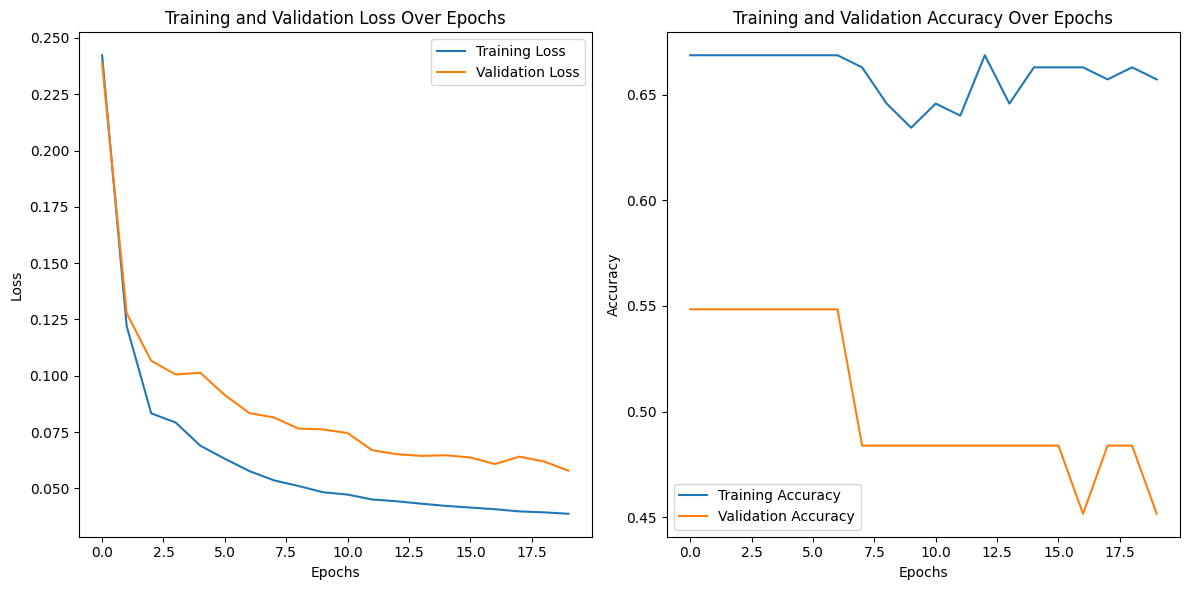

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Predicting

In [18]:
pred_y_t = model.predict(test_x_t)
pred_y = scaler_y.inverse_transform(pred_y_t)

2/2 [==============================] - 0s 2ms/step


In [19]:
pred_y[:5]

array([[  0.41371292, -30.38708   ,   9.692708  ],
       [  0.5955994 , -24.935198  ,   9.561556  ],
       [  0.39428458, -25.610416  ,   9.644576  ],
       [  0.75281906, -21.228739  ,  10.024784  ],
       [  0.360834  , -25.575478  ,   9.45685   ]], dtype=float32)

In [20]:
test_y[:5]

array([[  0.40105   , -50.37115571,   9.70900427],
       [  0.79012   , -25.54536089,   9.33511279],
       [  0.39115   , -24.77666787,   9.70033939],
       [  0.79408   , -20.4113367 ,  10.01617401],
       [  0.37135   , -28.15598845,   9.49240584]])

In [21]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score

import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay


def print_metrics(bar, model, x_test, y_test):
    predicted = model.predict(x_test)
    print(bar)

    display = PredictionErrorDisplay(y_true=y_test, y_pred=predicted)
    display.plot(kind="actual_vs_predicted")
    plt.show()

    print(f"R2 Score: {r2_score(y_test, predicted)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, predicted)}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, predicted)}")
    print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, predicted)}")
    print(f"Mean Absolute Error: {median_absolute_error(y_test, predicted)}")
    print(f"Explained Varaince Score: {explained_variance_score(y_test, predicted)}")

    print()

2/2 [==============================] - 0s 2ms/step
Neural Network


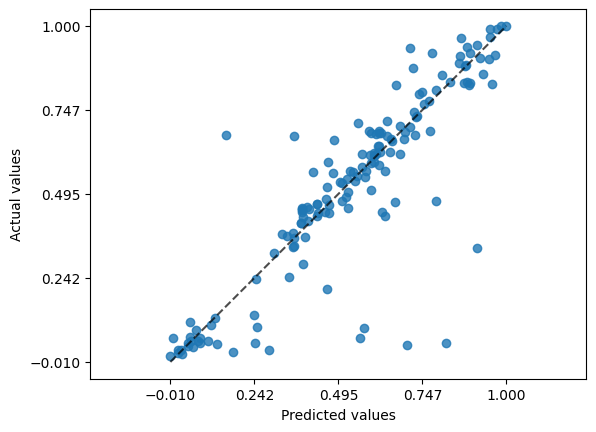

R2 Score: 0.7030883295639775
Mean Absolute Error: 0.07475698086417175
Mean Squared Error: 0.02028244343537354
Mean Absolute Percentage Error: 0.6419195430305498
Mean Absolute Error: 0.03635477747938246
Explained Varaince Score: 0.708112597164194



In [22]:
print_metrics("Neural Network", model, test_x_t, test_y_t)